<a href="https://colab.research.google.com/github/Mohammadhsiavash/DeepL-Training/blob/main/Unsupervised%2BSemi-Supervised/Self_Supervised_Pretraining_on_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Use a self-supervised learning task (image rotation prediction) to pretrain a model without labels, then fine-tune it for image classificaon.

In [1]:
!pip install tensorflow numpy matplotlib

Load and Preprocess the MNIST Dataset

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Load MNIST digits (no labels needed for SSL)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
# Reshape to (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
print("Shape:", x_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape: (60000, 28, 28, 1)


Create Rotated Images and Labels

In [4]:
def rotate_images(images):
  rotated = []
  labels = []
  for img in images:
    angle = np.random.choice([0, 90, 180, 270])
    # Convert NumPy array to TensorFlow Tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    if angle == 0:
      new_img_tensor = img_tensor
    elif angle == 90:
      new_img_tensor = tf.image.rot90(img_tensor, k=1)
    elif angle == 180:
      new_img_tensor = tf.image.rot90(img_tensor, k=2)
    else:
      new_img_tensor = tf.image.rot90(img_tensor, k=3)

    # Convert TensorFlow Tensor back to NumPy array
    rotated.append(new_img_tensor.numpy())
    labels.append(angle // 90) # label: 0,1,2,3
  return np.array(rotated), np.array(labels)

x_ssl, y_ssl = rotate_images(x_train[:10000])

Build the Rotaon Predicon Model

In [6]:
from tensorflow.keras import layers, models
# CNN to learn rotation features
def build_ssl_model():
  model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax') # 4 rotation classes
  ])
  return model
ssl_model = build_ssl_model()
ssl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the SSL Model

In [7]:
# Self-supervised training: Predict image rotation
ssl_model.fit(x_ssl, y_ssl, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7510 - loss: 0.6630 - val_accuracy: 0.9470 - val_loss: 0.1557
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.9582 - loss: 0.1271 - val_accuracy: 0.9620 - val_loss: 0.1360
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9734 - loss: 0.0818 - val_accuracy: 0.9730 - val_loss: 0.0915
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.9807 - loss: 0.0555 - val_accuracy: 0.9770 - val_loss: 0.0811
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9775 - loss: 0.0594 - val_accuracy: 0.9760 - val_loss: 0.0776


Visualize Learned Representaons

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


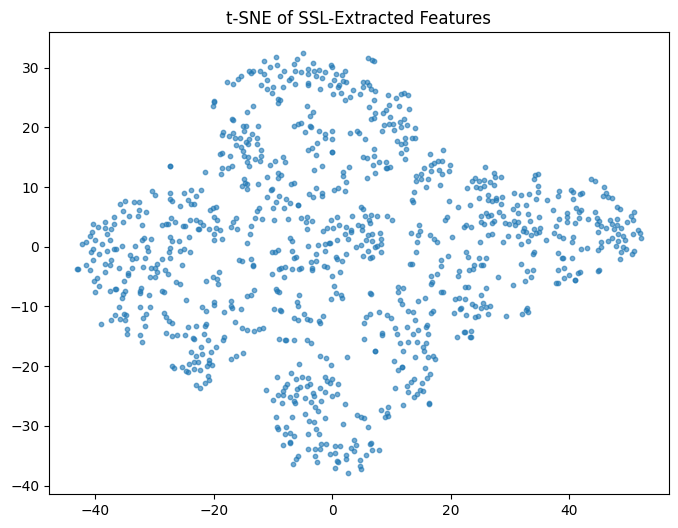

In [12]:
# Extract feature encoder from SSL model (up to penultimate layer)
encoder = models.Model(inputs=ssl_model.layers[0].input, outputs=ssl_model.layers[-2].output)
# Transform a subset of original images into feature vectors
features = encoder.predict(x_train[:1000])
# Visualize with t-SNE
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(features)
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6, s=10)
plt.title("t-SNE of SSL-Extracted Features")
plt.show()